# Ray Tracing

## Grundlagen

Was ist die grundlegende Idee von Raytracing?
Wichtig ist dafür zuerst zu verstehen wie Licht funktioniert.

Ein einfacher Ansatz dafür ist, anzunehmen das Licht aus Strahlen besteht.  
Diese Strahlen werden aus einer Lichtquelle ausgesendet, werden von Objekten reflektiert und absorbiert und zu guter Letzt kommen sie im Beobachters an.  
Der Beobachter wird hier Kamera genannt.

Schematisch und zwei dimensional sieht das so aus:
![][2d_ray_tracing]<!--TODO bild besser einfügen-->

Schritt für Schritt müssen also folgende Dinge geschehen: <!--TODO bessere Formulierung-->

1. Die Lichtquelle sendet einen Lichtstrahl aus
2. Dieser Lichtstrahl trifft auf ein Objekt
3. Das Objekt reflektiert und absorbiert teil des Lichtstrahls
4. Schritt 2 und 3 wiederholen sich bis der Lichtstrahl entweder eine Kamera oder kein Objekt mehr trifft
5. Lichtstrahl trifft auf die Kamera
6. Schritt 1 bis 6 werden wiederholt bis der Nutzer mit dem gerenderten Bild zufrieden ist

Dieser Ansatz ist allerdings sehr ineffizient, da dann viele Lichtstrahlen keine Kamera treffen.
Für eine bessere Optimierung werden die Lichtstrahlen aus der Kamera ausgesendet und der Lichtpfad wird erst nach dem Auftreffen auf die Lichtquelle vollständig berechnet.

<!--TODO bild durch nur kreise ersetzen-->
[2d_ray_tracing]: ./assets/2D_ray_tracing.png


## Lichtstrahlen (Rays)
    
Ein Lichtstrahl besteht aus Ortsvektor und Richtungsvektor.
Der Ortsvektor gibt dabei den Punkt an, an dem der Lichtstrahl ausgesendet wurde
und der Richtungsvektor die Richtung in die der Strahl gesendet wird.  
Also $\vec{ray(t)}=\vec{O}+\vec{d}*t$
außerdem hat ein Lichtstrahl eine Farbe `color`, die zu Beginn `[1,1,1]`

<!--TODO Bild-->

in Python definieren wir einen Ray so:

In [816]:
import numpy as np
import numpy.typing as npt
from typing import NamedTuple, Tuple

Vec = npt.NDArray[np.float64]
Color = npt.NDArray[np.float64]


class Ray(NamedTuple):
    location: Vec
    direction: Vec
    color: Color
    
    def at(self, t):
        return self.location + t * self.direction


Typischerweise ist der Richtungsvektor normiert, dafür dient diese Funktion

In [817]:
def normalizeVector(vec: Vec, usedAxis=None):
    return vec/np.linalg.norm(vec, axis=usedAxis, keepdims=True)

print(normalizeVector(np.array([[1.0, 2, 3], [1, 2, 3]]), 1))
print(normalizeVector(np.array([1, 2, 3])))


[[0.26726124 0.53452248 0.80178373]
 [0.26726124 0.53452248 0.80178373]]
[0.26726124 0.53452248 0.80178373]


## Aussenden eines Lichtstrahls

Die Kamera sendet Lichtstrahlen aus.
Die Kamera ist modelliert als eine Lochkamera. Es gibt einen Sensor, auf dem alle Pixel liegen. Der Sensor ist eine Fläche.
Alle Lichtstrahlen werden von den Pixeln des Sensors über einen Punkt, die Blende, ausgesendet.

<!--TODO Bild-->


In [818]:
class ImageSize(NamedTuple):
    width: int
    height: int

class Camera:
    def __init__(self, imageSize: ImageSize) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        self.imageSize = imageSize
        self.unitPerPixel = np.sqrt(self.imageSize.width ** 2 + self.imageSize.height ** 2)
        self.sensorPosition = np.array([1,0,0])
        self.aperturePosition = np.array([0,0,0])
    
    def _getRay(self, pixelX:int,pixelY:int) -> Ray:
        assert 0 <= pixelX < self.imageSize.width, f"pixelX has to be in Image, was {pixelX}" 
        assert 0 <= pixelY < self.imageSize.height, f"pixelY has to be in Image, was {pixelY}"
        x = -self.imageSize.width/2 + pixelX
        y = -self.imageSize.height/2 + pixelY
        pixelPos = self.sensorPosition + np.array([0, x/self.unitPerPixel, y/self.unitPerPixel])
        rayDirection = normalizeVector(pixelPos - self.aperturePosition)
        return Ray(self.aperturePosition, rayDirection, np.array([1,1,1])) # TODO eigentlich is es falsch mit 1,1,1 anzufangen...

camera = Camera(ImageSize(128, 128))
camera._getRay(0,0)

Ray(location=array([0, 0, 0]), direction=array([ 0.89442719, -0.31622777, -0.31622777]), color=array([1, 1, 1]))


## Schnittpunkt eines Lichtstrahls mit einem Objekt

Nachdem der Lichtstrahl ausgesendet wurde, muss der erste Auftreffpunkt des Lichtstrahls auf einem Objekt berechnet werden.
Hier werden zur Vereinfachung nur Kreise als Objekte genutzt. 
Schnittpunkte sind dabei alle Punkte, die genau den Radius $r$ des Kreises von dessen Mittelpunkt $C$ entfernt sind.
also:

$$
||\vec{P}-\vec{C}||=r
$$

Für die Lichtstrahlen gilt damit

$$
||\vec{ray(t)}-\vec{C}||=r
$$
$$
||\vec{O}+\vec{d}*t-\vec{C}|| = r
$$

umgeformt ergibt das eine Quadratische Gleichung:

$$
||\vec{d}||^2*t^2+2t*<\vec{d},\vec{O}-\vec{C}>+<\vec{O}-\vec{C},\vec{O}-\vec{C}>-r^2=0
$$

um die Schnittpunkte heruaszufinden, muss die Gleichung nacht $t$ aufgelöst werden. 
Das wird hier in code umgesetzt.

In [819]:
from abc import ABC, abstractmethod 
from typing import Optional


class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[float]:
        pass

class Circle(Object):
    def __init__(self, center: Vec, radius: float) -> None:
        self.center = center
        self.radius = radius
        super().__init__()

    def hit(self, ray: Ray) -> Optional[float]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = list(filter(lambda x: x > 0, [t1,t2]))
            if len(t)==0:
                return None
            return min(t)
        return None
    

ray = Ray(np.array([0,0,0]),np.array([1,0,0]), np.array([1,1,1]))
circle: Object = Circle(np.array([5,0,0]),1)
circle.hit(ray)

4.0

Diese Berechnung muss nun für alle Objekte gemacht werden. Dabei ergeben sich voraussichtlich mehrere Werte für $t$.
Der Auftreffpunkt des Lichtstrahls ist der Punkt, für den $t$ minimal aber größer Null ist. 

## Erster Test

Nun kann alles ein erstes Mal getestet werden.
Dafür wird eine einfache Render Funktion erstellt.
Diese kann unterscheiden, ob ein Objekt mit einem Lichtstrahl getroffen wurde oder nicht.

<!--TODO text hier-->

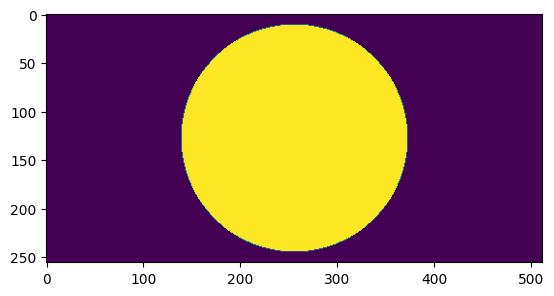

In [820]:
import matplotlib.pyplot as plt

camera = Camera(ImageSize(256, 512))
objects: list[Object] = [Circle(np.array([5, 0, 0]), 1)]

def render(camera: Camera, objects: list[Object]):
    img = np.zeros(camera.imageSize)
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) > 0:
                img[x, y] = 1
    return img
plt.imshow(render(camera, objects))

## Materialien

Bis jetzt gibt es nur zwei Zustände: Der Lichtstrahl trifft ein Objekt und der Lichtstrahl trifft kein Objekt.
Das reicht allerdings nicht aus, um ein Bild zu erzeugen. Dafür werden nun Materialien eingeführt, die den Objekten eine Farbe geben. 

In [821]:
# NEU: es gibt ein Material, in dem eine Farbe deffiniert ist
class Material():
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

# NEU: wenn ein Objekt getroffen wird, muss zusätzlich das Material des Objekts zurück gegeben werden
class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[Tuple[float, Material]]:
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray) -> Optional[Tuple[float, Material]]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            t = list(filter(lambda x: x > 0, [t1, t2]))
            if len(t) == 0:
                return None
            return (min(t), self.material)
        return None


Mit der Einführung von Materialien muss auch die Rendering Funktion angepasst werden.

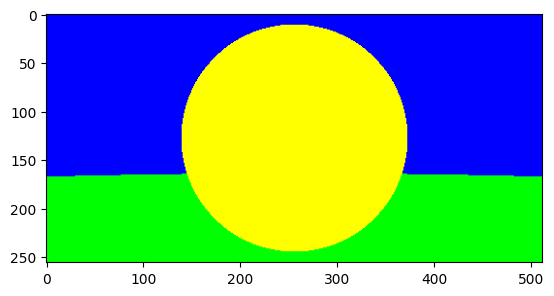

In [822]:
camera = Camera(ImageSize(256, 512))
objects: list[Object] = [Circle(np.array([50, 0, 0]), 10, Material([1,1,0])),
                         Circle(np.array([0, 5000, 0]), 4990, Material([0, 1, 0])),
                         Circle(np.array([0, 0, 0]), 5000, Material([0, 0, 1]))]

def render(camera: Camera, objects: list[Object]):
    img = np.zeros((camera.imageSize.width,camera.imageSize.height, 3))
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            hits: list[Tuple[float, Material]] = []
            for obj in objects:
                hit = obj.hit(ray)
                if hit is not None:
                    hits.append(hit)
            if len(hits) == 0:
                img[x, y] = [0,0,0]
                continue
            criticalHit = min(hits, key=lambda hit: hit[0])
            img[x,y] = criticalHit[1].color * ray.color
    return img
plt.imshow(render(camera, objects))


## Lichtstrahl Reflexion/Absorption

Jetzt wollen wir, dass Lichtstrahlen von Objekten mehrfach abprallen können.
Dafür wird ein Algorithmus benötigt, der das Abprallen der Lichtstrahlen abbildet.
Um das umsetzten zu können, muss bei einem Auftreffen eines Lichtstrahls neben dem Material, das Objektes auch ein Normalen Vektor des Auftreffpunkts zurückgegeben werden.
Dieser wird genutzt, um den weitergehenden ausgehenden Lichtstrahl zu bestimmen.

In [823]:
# NEU: neben dem Material, muss nun auch der Normalen Vektor des Objekts zurückgegeben werden
# Um den Rückgabewert lesbarer zu machen, wird ein Rückgabeobjekt eingeführt

class ObjHit(NamedTuple):
    t: float
    material: Material
    normal: Vec

class Object(ABC):
    @abstractmethod
    def hit(self, ray: Ray) -> Optional[ObjHit]:
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def hit(self, ray: Ray) -> Optional[ObjHit]:
        a = 1
        b = 2 * np.dot(ray.direction, ray.location - self.center)
        c = np.linalg.norm(ray.location - self.center) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c
        if delta > 0:
            t1 = (-b + np.sqrt(delta))/(2*a)
            t2 = (-b - np.sqrt(delta))/(2*a)
            # return only the first hit and only if its > 0
            tAll = list(filter(lambda x: x > 0, [t1, t2]))
            if len(tAll) == 0:
                return None
            t = min(tAll)
            # calculate the normal vector
            normal = normalizeVector(ray.at(t) - self.center)
            return ObjHit(t, self.material, normal)
        return None

Ein einfaches Material ist ein Diffuses Material. 
Dafür wird die Lambertsche Reflektion verwendet.
Es wird von der Normalen aus in Abstand $1$ eine Einheitskugel erstellt.
Dann wird ein Punkt auf der Oberfläche der Kugel ausgewählt.
Die Reflektion ist dann der Vektor von dem Auftreffpunkt zu dem Punkt auf der Oberfläche der Kugel.

Es ist also nötig einen zufälligen Punkt auf der Kugeloberfläche zu wählen.
Das wird hier mit der folgenden Funktion implementiert

In [824]:
def randomOnUnitSphere() -> Vec:
    randNumber = np.random.randn(3)
    return randNumber / np.linalg.norm(randNumber)

randomOnUnitSphere()

array([-0.58387228,  0.62432807, -0.51894857])

Mit diesem Wissen kann ein neues Material implementiert werden,
da es mehrere verschiedene Materialien geben wird,
wird ein Material als abstrakte Klasse implementiert.
Diese hat eine Funktion, die mit dem eingehenden Lichtstrahl, dem Normalenvektor und dem Auftreffpunkt, den ausgehenden Lichtstrahl berechnet.

Neben dem diffusen Material muss es auch noch eine Lichtquelle geben. 
Dieses wird auch als Material, dem Emissive Material, implementiert.
Ein diffuses Material reflektiert allerdings keine Lichtstrahlen und muss damit beim Rendern das Rendering abbrechen.

In [825]:
# NEU: ein Material deffiniert eine Methode die mit dem eigehenden Lichtstrahl
# aus dem eingehenden Lichtstrahl berechnet
# Das Material ist außerdem abstrakt
class Material(ABC):
    @abstractmethod
    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        pass


# NEU: das Diffuse Material
class Diffuse(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        point = randomOnUnitSphere() + normalizeVector(normal) + hitPoint
        direction = normalizeVector(point - hitPoint)
        location = hitPoint
        color = inRay.color * self.color
        return Ray(location, direction, color)

# NEU: das Emmisive Material
class Emissive(Material):
    def __init__(self, color) -> None:
        self.color = color
        super().__init__()

    def outRay(self, inRay: Ray, normal: Vec, hitPoint: Vec) -> Ray:
        direction = np.array([0,0,0])
        location = np.array([0,0,0])
        color = inRay.color * self.color
        return Ray(location, direction, color)


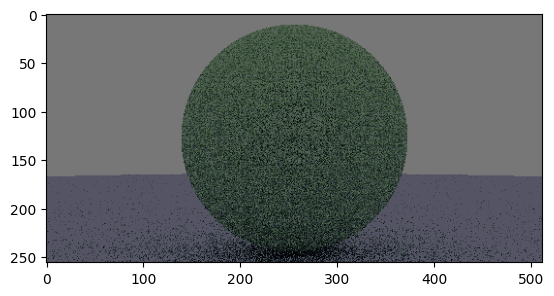

In [826]:
camera = Camera(ImageSize(256, 512))
objects: list[Object] = [Circle(np.array([50, 0, 0]), 10, Diffuse([0.5, 0.7, 0.5])),
                         Circle(np.array([0, 5000, 0]),
                                4990, Diffuse([0.5, 0.5, 0.7])),
                         Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5]))]

def render(camera: Camera, objects: list[Object]):
    img = np.zeros((camera.imageSize.width, camera.imageSize.height, 3))
    for x in range(camera.imageSize.width):
        for y in range(camera.imageSize.height):
            ray = camera._getRay(x, y)
            for i in range(10):
                hits = []
                for obj in objects:
                    hit = obj.hit(ray)
                    if hit is not None:
                        hits.append(hit)
                if len(hits) == 0:
                    img[x, y] = [0, 0, 0]
                    break
                criticalHit = min(hits, key=lambda hit: hit[0])
                point = ray.at(criticalHit.t)
                ray = criticalHit.material.outRay(ray, criticalHit.normal, point)
                if all(map(lambda x: x==0, ray.direction)):
                    break
            img[x, y] = ray.color
    return img

img = render(camera,objects)
img = img/50
img = np.sqrt(img*2.2) # Gamma 2.2
plt.imshow(img)


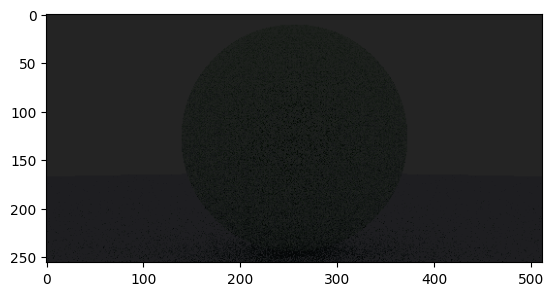

In [827]:
n = img/50
n = np.sqrt(n*2.2)
plt.imshow(n)

## Optimierungen

In [836]:
Vec = npt.NDArray[np.float64]


class Camera:
    def __init__(self, imageSize: ImageSize) -> None:
        assert 0 < imageSize.width and 0 < imageSize.height, f"image cant have negative Dimestions, was {imageSize}"
        self.imageSize = imageSize
        self.sensorPosition = np.array([1, 0, 0])
        self.aperturePosition = np.array([0, 0, 0])

    def getRays(self):
        x = np.linspace(-1, 1, self.imageSize.width)
        y = np.linspace(-1, 1, self.imageSize.height)
        xx, yy = np.meshgrid(x, y)
        grid = np.array([np.zeros(xx.shape), xx, yy])
        # this is the sensor Plane
        grid = grid.T
        grid = grid.reshape((self.imageSize.width*self.imageSize.height, 3))
        
        pixelPos = self.sensorPosition + grid
        rayDirection = normalizeVector(pixelPos - self.aperturePosition,1)

        rayLocation = np.zeros(rayDirection.shape)
        rayLocation += self.aperturePosition
        rayColor = np.zeros(rayDirection.shape)
        rayColor += np.array([1, 1, 1])
        rays = np.array([rayLocation, rayDirection, rayColor])
        return rays.transpose((1, 0, 2))


rays = Camera(ImageSize(2, 2)).getRays()
print(rays)

[[[ 0.          0.          0.        ]
  [ 0.57735027 -0.57735027 -0.57735027]
  [ 1.          1.          1.        ]]

 [[ 0.          0.          0.        ]
  [ 0.57735027 -0.57735027  0.57735027]
  [ 1.          1.          1.        ]]

 [[ 0.          0.          0.        ]
  [ 0.57735027  0.57735027 -0.57735027]
  [ 1.          1.          1.        ]]

 [[ 0.          0.          0.        ]
  [ 0.57735027  0.57735027  0.57735027]
  [ 1.          1.          1.        ]]]


In [841]:

class Object(ABC):
    @abstractmethod
    def hit(self, rays):
        pass


class Circle(Object):
    def __init__(self, center: Vec, radius: float, material: Material) -> None:
        self.center = center
        self.radius = radius
        self.material = material
        super().__init__()

    def _elemwiseDot(self, a,b):
        return np.sum(a*b, axis=1)

    def hit(self, rays):
        # get location and direction arrays
        locations = rays[:, 0::3,:].squeeze(1)
        directions = rays[:, 1::3].squeeze(1)

        # calculate b, c and delta
        a = 1
        b = 2 * self._elemwiseDot(directions, (locations - self.center))
        c = np.linalg.norm(locations - self.center, axis=1) ** 2 - self.radius ** 2
        delta = b ** 2 - 4*a*c

        # filter out all values for which delta is < 0 and set delta to 0 there
        filter = [d >= 0 for d in delta]
        delta = np.where(filter, delta, 0)
        
        # calculate t1 and t2
        rootDelta = np.sqrt(delta)
        t1 = (-b + rootDelta)/(2*a)
        t2 = (-b - rootDelta)/(2*a)

        # take the smallest t or 0 if t<0
        t = np.minimum(t1,t2)
        t = np.where(t >= 0, t, np.maximum(t1,t2))
        t = np.where(t>=0, t, np.inf)
        t = np.where(filter, t, np.inf)

        return t


rays = np.array([
    [[0, 0, 0],[1, 0, 0],[1, 1, 1]],
    [[0, 0, 0], [1, 0, 0], [1, 1, 1]],
    [[0, 10, 0],[1, 0, 0],[1, 1, 1]]
    ])
circle: Object = Circle(np.array([5, 0, 0]), 1, Diffuse(np.array([0,0,0])))
circle.hit(rays)


array([ 4.,  4., inf])

In [858]:
def render(camera: Camera, objects: list[Object], samples):
    img = np.zeros((camera.imageSize.width, camera.imageSize.height, 3))
    rays = camera.getRays()

    # it has to be ensured that every ray always hits an Object
    for i in range(samples):
        hits = np.asarray([obj.hit(rays) for obj in objects])
        hits = hits.T
        hitIndexes = hits.argmin(axis=1)
        print(hitIndexes)
        materials = [objects[hit].material for hit in hitIndexes]


camera = Camera(ImageSize(8, 8))
objects: list[Object] = [Circle(np.array([50, 0, 0]), 10, Diffuse([0.5, 0.7, 0.5])),
                         Circle(np.array([0, 5000, 0]),
                                4990, Diffuse([0.5, 0.5, 0.7])),
                         Circle(np.array([0, 0, 0]), 5000, Emissive([5, 5, 5]))]
render(camera, objects, 1)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 1 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
